In [1]:
#!/usr/bin/env python
"""choose_skies.ipynb: a notebook to create and examine GW backgrounds """

__author__ = "Chiara M. F. Mingarelli"
__copyright__ = "Copyright 2016, GWASAP project"
__credits__ = ["Chiara Mingarelli", "Stephen Taylor"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Chiara Mingarelli"
__email__ = "mingarelli@gmail.com"


In [2]:
from __future__ import division
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
import healpy as hp
import plot_mpl2 as plot
from astropy.io import fits

import AnisCoefficients_pix as cbylm_pix 

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
freq_choice = np.loadtxt("gw_freqs.dat") #available GW frequencies

In [4]:
# source sky

sim_sky_all = np.genfromtxt("example_sky/herc_1249_test_2017-02-28-16:05:40_10.txt")
RA_tot_all = sim_sky_all[:,0] #phi, add pi to this for healpix maps
DEC_tot_all = sim_sky_all[:,1] #theta
freq_all = sim_sky_all[:,2]
strain_vec_all = sim_sky_all[:,3]
file_size_all = strain_vec_all.size # number of galaxies in file



In [5]:
# source sky, source removed from row 71

sim_sky_noise = np.delete(sim_sky_all, 69, axis = 0)
RA_tot_noise = sim_sky_noise[:,0] #phi, add pi to this for healpix maps
DEC_tot_noise = sim_sky_noise[:,1] #theta
freq_noise = sim_sky_noise[:,2]
strain_vec_noise = sim_sky_noise[:,3]
file_size_noise = strain_vec_noise.size # number of galaxies in file


In [6]:
# A map of the sky realization where the detection was made

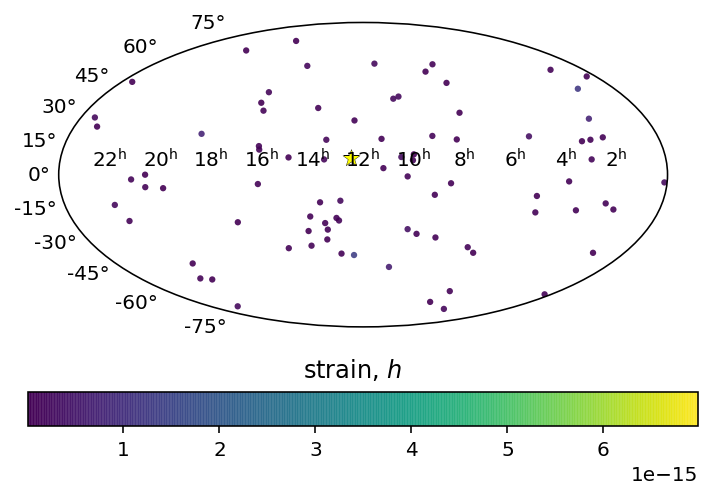

In [7]:
ax = plt.subplot(111, projection='astro mollweide')

# plot "noise" map (GW sky with 2 loud sources removed)
#ax.grid()
#plot.outline_text(ax)
maxstrain = np.amax(strain_vec_all)
colors = (strain_vec_all) # make colors vary with respect to strain
#area = pi * (15 * strain_vec/maxstrain)**2  # adapt circles with 0 to 15 point radii

# labels
plt.suptitle(r'strain, $h$', y=0.3)
sc = plt.scatter(RA_tot_all, DEC_tot_all, c = colors, cmap = 'viridis', alpha = 0.9, edgecolors='none',s=10)
#plt.suptitle(r'strain, h$', y=0.3)
plt.scatter(187.445*pi/180, 8.00000000003*pi/180, color ='yellow', marker = '*', s=80,\
           edgecolor = "black", lw=0.2)
#plt.scatter(187.445*pi/180, 8.00000000003*pi/180, color ='yellow', marker = '*', s=50)

plt.colorbar(sc, orientation = 'horizontal')
#plt.savefig("NGC4472_mapWsource.pdf")

In [8]:
# What does the GW background look like from this sky?

In [9]:
def h2_c(hk, fk, deltaF):
    """
    Eq 35 Babak et al. 2016; 
    Given a sky of strains at certain frequencies,
    what is it in terms of a GW background?
    returns h^2_c
    """
    h2k = np.square(hk)
    ans = h2k*fk/deltaF
    return ans


def pol2cart(lon, lat): 
    """ 
    Utility function to convert longitude,latitude on a unit sphere to 
    cartesian co-ordinates.

    """ 

    x = np.cos(lat)*np.cos(lon) 
    y = np.cos(lat)*np.sin(lon) 
    z = np.sin(lat) 

    return np.array([x,y,z])


def greedy_bin_sky(skypos, skycarts, weights=None):
    """

    Greedy binning algorithm

    """

    N = len(skycarts) 
    skycarts = np.array(skycarts)
    bins = np.zeros(N)
    ct = 0
    for raSample, decSample in skypos: 
        sampcart = pol2cart(raSample, decSample) 
        dx = np.dot(skycarts, sampcart)
        maxdx = np.argmax(dx)

        if weights is not None:
            bins[maxdx] += weights[ct]
        else:
            bins[maxdx] += 1

        ct += 1

    # fill in skymap
    histIndices = np.argsort(bins)[::-1]    # in decreasing order
    NSamples = len(skypos)

    frac = 0.0
    skymap = np.zeros(N)
    for i in histIndices:
        frac = float(bins[i]) # /float(NSamples) 
        skymap[i] = frac

    return skymap


def plotSkyMap(raSample, decSample, nside=64, contours=None, colorbar=True, \
              inj=None, weights=None, psrs=None):
    """

    Plot Skymap of chain samples on Mollwiede projection.

    @param raSample: Array of right ascension samples
    @param decSample: Array of declination  samples
    @param nside: Number of pixels across equator [default = 64]
    @param contours: Confidence contours to draw eg. 68%, 95% etc
                     By default this is set to none and no contours
                     will be drawn.
    @param colorbar: Boolean option to draw colorbar [default = True]
    @param inj: list of injected values [ra, dec] in radians to plot
                [default = None]
    @param weights: sample weights [default = None]
    @param psrs: Stacked array of pulsar sky locations [ra, dec] in radians
                 [default=None] Will plot as white diamonds

    """

    # clear figures
    plt.clf()

    # create stacked array of ra and dec
    skypos = np.column_stack([raSample, decSample])

    npix = hp.nside2npix(nside)    # number of pixels total


    # initialize theta and phi map coordinantes
    skycarts=[]
    for ii in range(npix):
        skycarts.append(np.array(hp.pix2vec(nside,ii)))

    # get skymap values from greedy binning algorithm
    skymap = greedy_bin_sky(skypos, skycarts, weights)

    # smooth skymap
    skymap = hp.smoothing(skymap, 0.1)

    # make plot
    ax = plt.subplot(111, projection='astro mollweide')

    # plot map
    #ax.grid()
    plot.outline_text(ax)
    plot.healpix_heatmap(skymap, cmap = 'viridis')

    return skymap
    # save skymap
    #plt.savefig('skymap.pdf', bbox_inches='tight')

In [10]:
T = 315360000*2.5 # 25 years in seconds, consistent with EPTA data
dF = 1/T

In [11]:
#
hc_strain_noise = np.sqrt(h2_c(strain_vec_noise, freq_noise, dF))
hc_strain_all = np.sqrt(h2_c(strain_vec_all, freq_all, dF))

In [12]:
hc_strain_noiseLog = np.log10(hc_strain_noise)

Sigma is 145.987664 arcmin (0.042466 rad) 
-> fwhm is 343.774677 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/anaconda2/lib/python2.7/site-packages/matplotlib/projections/geo.py:485: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


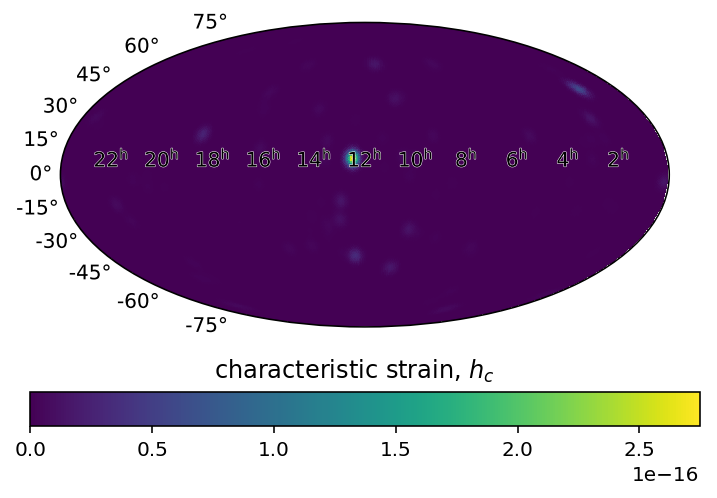

In [13]:
hpskymap_all = plotSkyMap(RA_tot_all, DEC_tot_all , weights = hc_strain_all)
plt.suptitle(r'characteristic strain, $h_c$', y=0.3)
plt.colorbar(orientation='horizontal')
plt.savefig('new2b.pdf', bbox_inches='tight')

Sigma is 145.987664 arcmin (0.042466 rad) 
-> fwhm is 343.774677 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


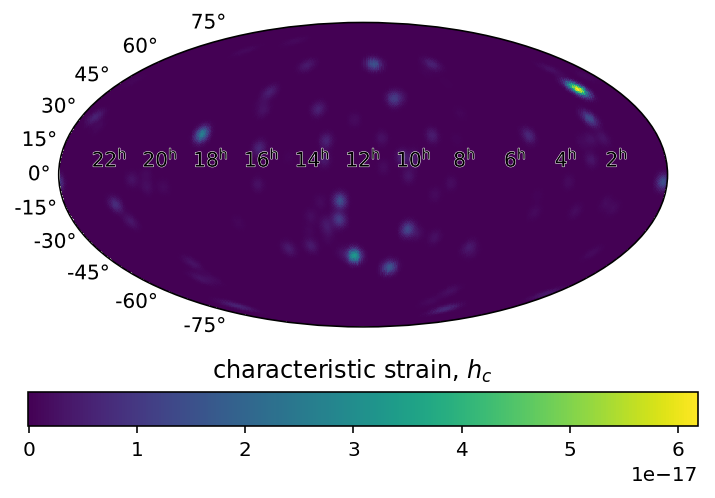

In [14]:
hpskymap_noise = plotSkyMap(RA_tot_noise, DEC_tot_noise , weights = hc_strain_noise)
plt.suptitle(r'characteristic strain, $h_c$', y=0.3)
plt.colorbar( orientation='horizontal')
plt.savefig('new2c.pdf', bbox_inches='tight')

In [15]:
hp.pixelfunc.remove_monopole(hpskymap_all)

monopole: 6.42679e-19


array([ -7.99005535e-19,  -8.04786322e-19,  -8.02390506e-19, ...,
        -5.81735201e-19,  -5.95378248e-19,  -5.98994802e-19])

In [16]:
# create alm map form healpix map
alm_map_noise = hp.map2alm(hpskymap_noise,lmax=10)
alm_map_all = hp.map2alm(hpskymap_all,lmax=10)

# make a map in terms of \ell from the alm map
hpskymap_lmax_noise = hp.alm2map(alm_map_noise,nside=64)
hpskymap_lmax_all = hp.alm2map(alm_map_all,nside=64)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [17]:
hpskymap_lmax_noise[hpskymap_lmax_noise < 0.0] = 0.0
hpskymap_lmax_all[hpskymap_lmax_all < 0.0] = 0.0

In [18]:
# What does this sky look like in terms of an anisotropic background?

Sigma is 145.987664 arcmin (0.042466 rad) 
-> fwhm is 343.774677 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 145.987664 arcmin (0.042466 rad) 
-> fwhm is 343.774677 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


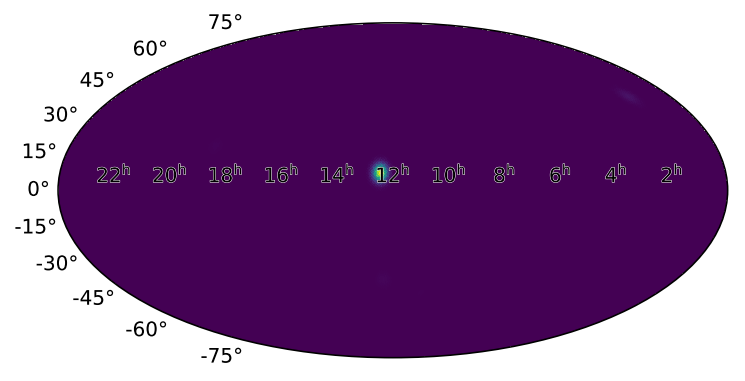

In [19]:
# h^2_c for C_l decomposition

hpskymap2_noise = plotSkyMap(RA_tot_noise, DEC_tot_noise , weights = hc_strain_noise**2)
hpskymap2_all = plotSkyMap(RA_tot_all, DEC_tot_all, weights = hc_strain_all**2)

# create alm map form healpix map

alm_map2_noise = hp.map2alm(hpskymap2_noise,lmax=10)
alm_map2_all = hp.map2alm(hpskymap2_all,lmax=10)

# make a map in terms of \ell from the alm map

hpskymap_lmax2_noise = hp.alm2map(alm_map2_noise,nside=64)
hpskymap_lmax2_all = hp.alm2map(alm_map2_all,nside=64)


In [20]:
## Decompose this onto real spherical harmonics with our standard normalisations
lmax = 50

clm_noise = cbylm_pix.clmFromMap_fast(hpskymap2_noise, lmax)
clm_all = cbylm_pix.clmFromMap_fast(hpskymap2_all, lmax)

In [21]:
## Make the angular power spectrum, Cl = \sum_m |clm|^2 / (2l+1)

Cl_all = np.zeros(lmax+1)
for ll in range(0,lmax+1):
    Cl_all[ll] = np.sum(clm_all[ll**2:(ll+1)**2]**2.0) / (2.0*ll+1.0) / (4.0*pi)

In [22]:
## Make the angular power spectrum, Cl = \sum_m |clm|^2 / (2l+1)

Cl_noise = np.zeros(lmax+1)
for ll in range(0,lmax+1):
    Cl_noise[ll] = np.sum(clm_noise[ll**2:(ll+1)**2]**2.0) / (2.0*ll+1.0) / (4.0*pi)

In [23]:
# plotting preamble (credit J. Ellis)

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

(0, 50)

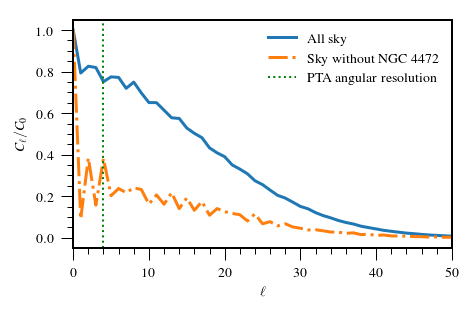

In [24]:
## Let's take a look

fig, ax = plt.subplots() 
ax.plot(np.arange(0,lmax+1),Cl_all/Cl_all[0], label = "All sky",  lw=1.5)
ax.plot(np.arange(0,lmax+1),Cl_noise/Cl_noise[0], label = "Sky without NGC 4472", lw=1.5,linestyle = '-.')
ax.set_xlabel('$\ell$')
ax.set_ylabel('$C_\ell/C_{0}$')
ax.minorticks_on()
plt.axvline(x=4, ymin=0, ymax = 1, linewidth=1.0, linestyle =":", label = "PTA angular resolution", c='g')
ax.legend(loc='best',frameon=False)
plt.xlim(0,50)
#plt.savefig('../manuscript/plots/Cl_NGC472_wLimit.pdf',bbox_inches='tight')